Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах.  
Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.  
 
<big><b>Задача</big> 

Необходимо построить модель для предсказия количества заказов такси на следующий час.  
Значение метрики RMSE на тестовой выборке должно быть не больше 48.


1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.



Данные лежат в файле /datasets/taxi.csv   
Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).


<big><b>План выполнения работы</big>

- Подготовка Данных
- Анализ данных
- Обучение моделей
- Тестирование моделей
- Выводы

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from math import sqrt


In [2]:
import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None

sns.set(style="darkgrid")

#randomstate
SEED = 12345

## Подготовка данных

In [3]:
# Загрузим датасеты с помощью конструкции обработки исключений

try:
    df = pd.read_csv('/datasets/taxi.csv')
    print('Прочитан файл с данными: df')
except:
    print(repr(err))

Прочитан файл с данными: df


In [4]:
df.sort_index(inplace=True)

In [5]:
df.head(10)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [7]:
# Приведём признак datetime к типу datetime

df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')

In [8]:
# Выполниь ресемплирование данных по одному часу.

df = df.set_index('datetime').resample('1H').sum()

In [9]:
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


In [10]:
print(df.index.is_monotonic)

True


In [11]:
f"Временной промежуток данных: от {df.index.min()} до {df.index.max()}"

'Временной промежуток данных: от 2018-03-01 00:00:00 до 2018-08-31 23:00:00'

Промежуток времени в данных с 1 марта 2018 года по 31 августа 2018 года

## Анализ данных

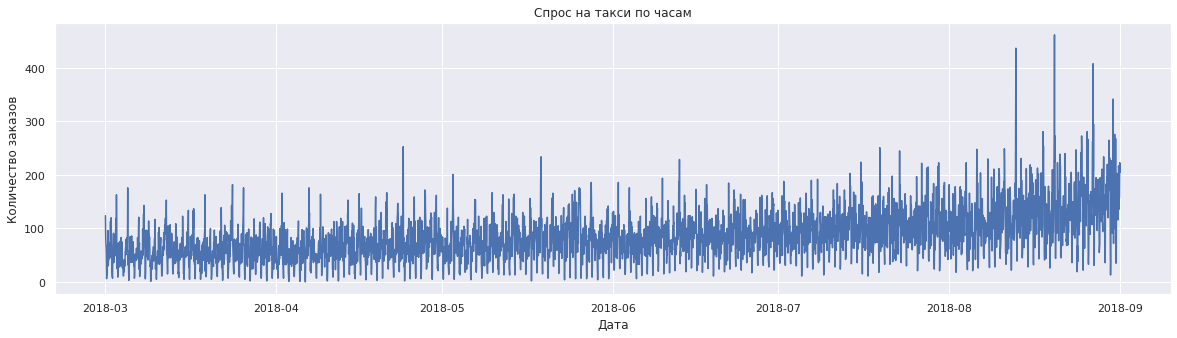

In [12]:
plt.figure(figsize=(20,5))
ax = sns.lineplot(x=df.index, y=df['num_orders'], color='b')
ax.set(xlabel='Дата', 
ylabel='Количество заказов', 
title='Спрос на такси по часам')
plt.show()

Посмотрим на спрос за один месяц

In [13]:
df_may = df['2018-05-01':'2018-05-31']
df_may.head()

,num_orders
datetime,
2018-05-01 00:00:00,81
2018-05-01 01:00:00,74
2018-05-01 02:00:00,55
2018-05-01 03:00:00,84
2018-05-01 04:00:00,77


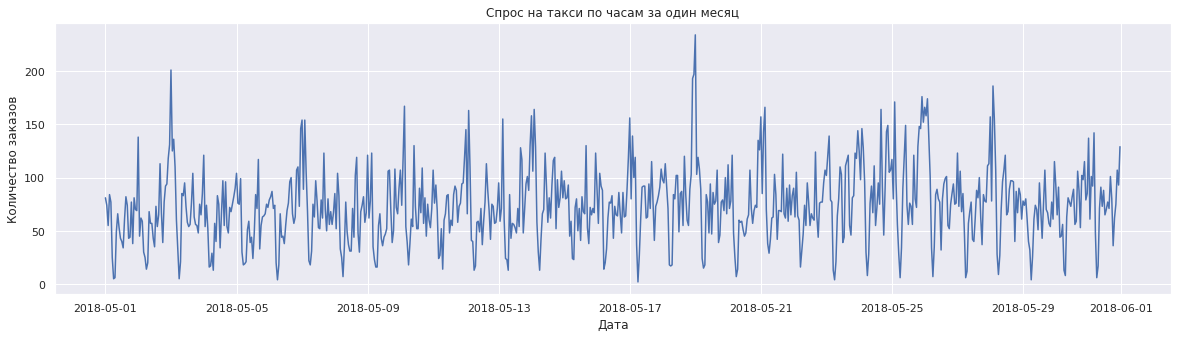

In [14]:
plt.figure(figsize=(20,5))
ax = sns.lineplot(x=df_may.index, y=df_may['num_orders'], color='b')
ax.set(xlabel='Дата', 
ylabel='Количество заказов', 
title='Спрос на такси по часам за один месяц')
plt.show()

Разложим данные на тренд, сезонность и остаток. Посмотрим на графики за период в три месяца

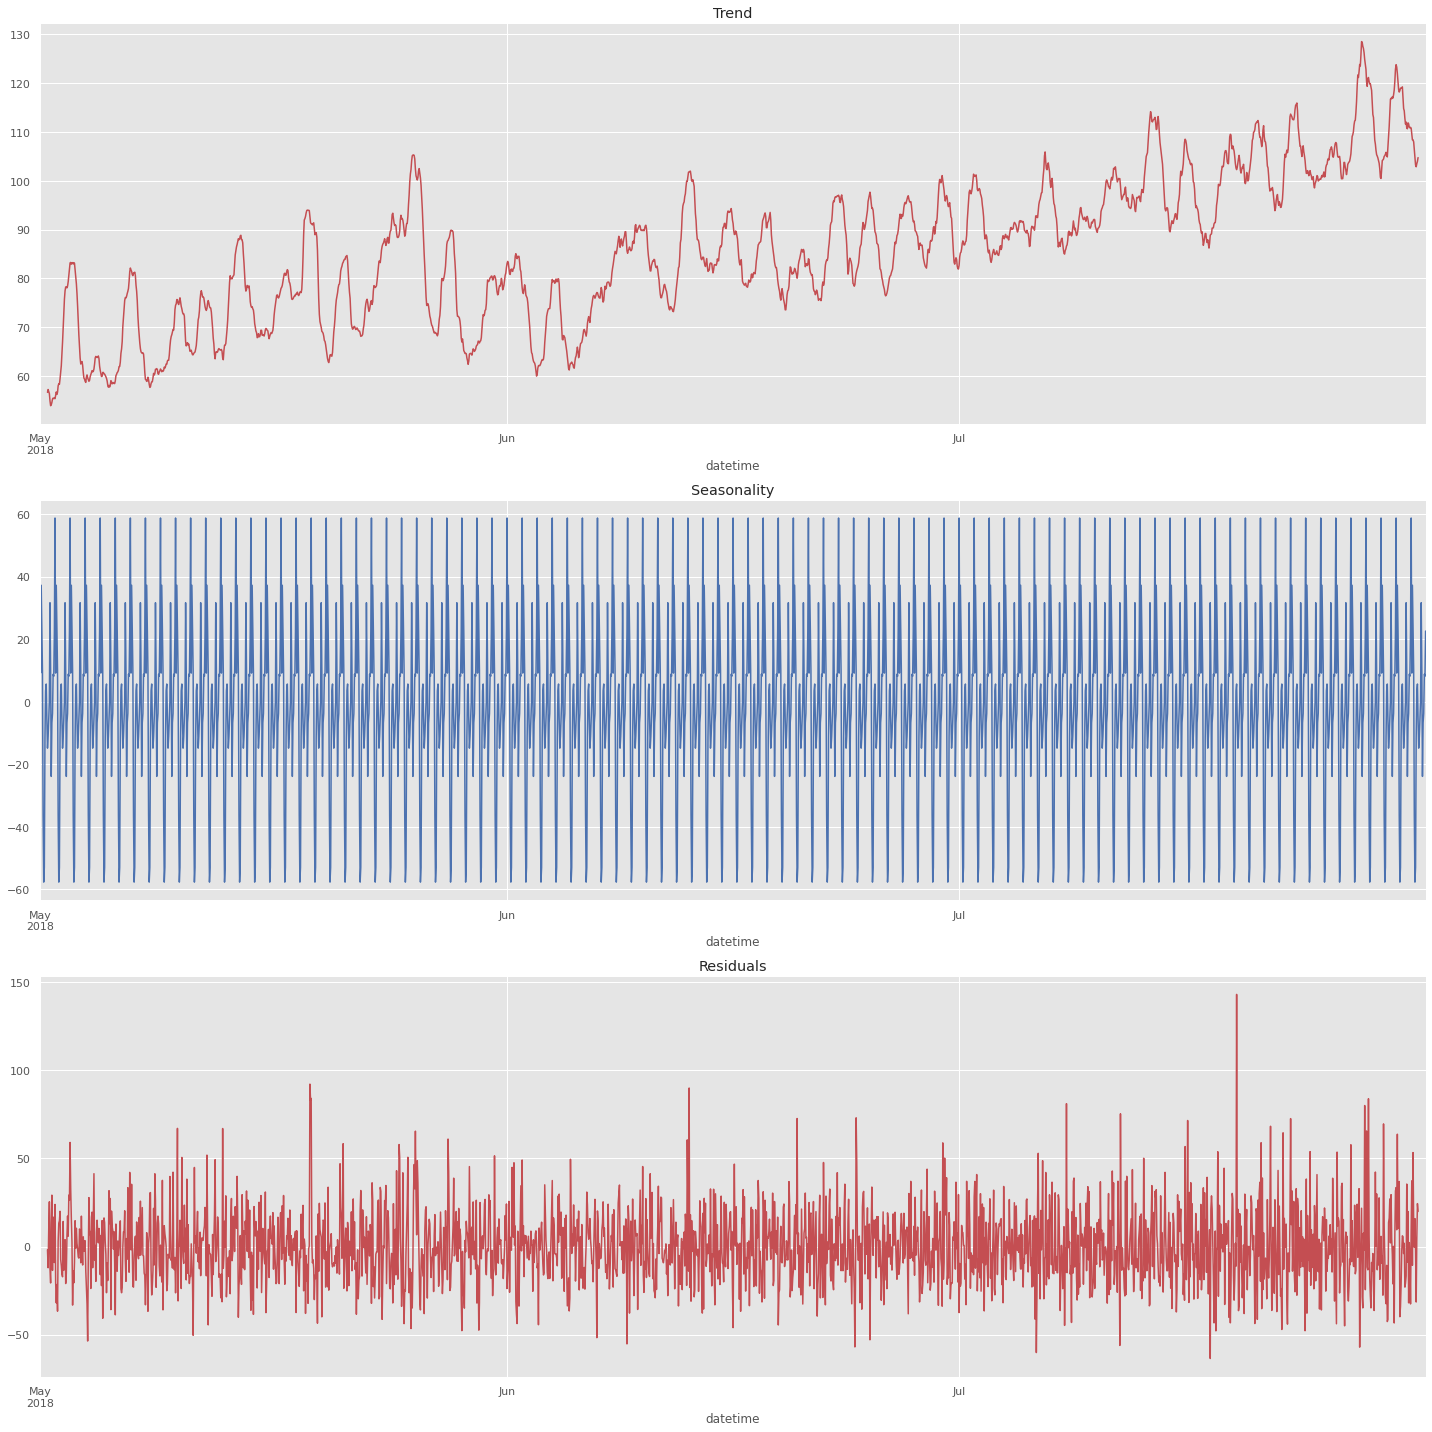

In [15]:
plt.style.use('ggplot')
decomposed = seasonal_decompose(df['2018-05':'2018-07'])
plt.figure(figsize=(20, 20))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca(), color='r')
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), color='b')

plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), color='r')

plt.title('Residuals')
plt.tight_layout()

Посмотрим тренд за неделю

In [16]:
df_2week = df['2018-07-02':'2018-07-15']

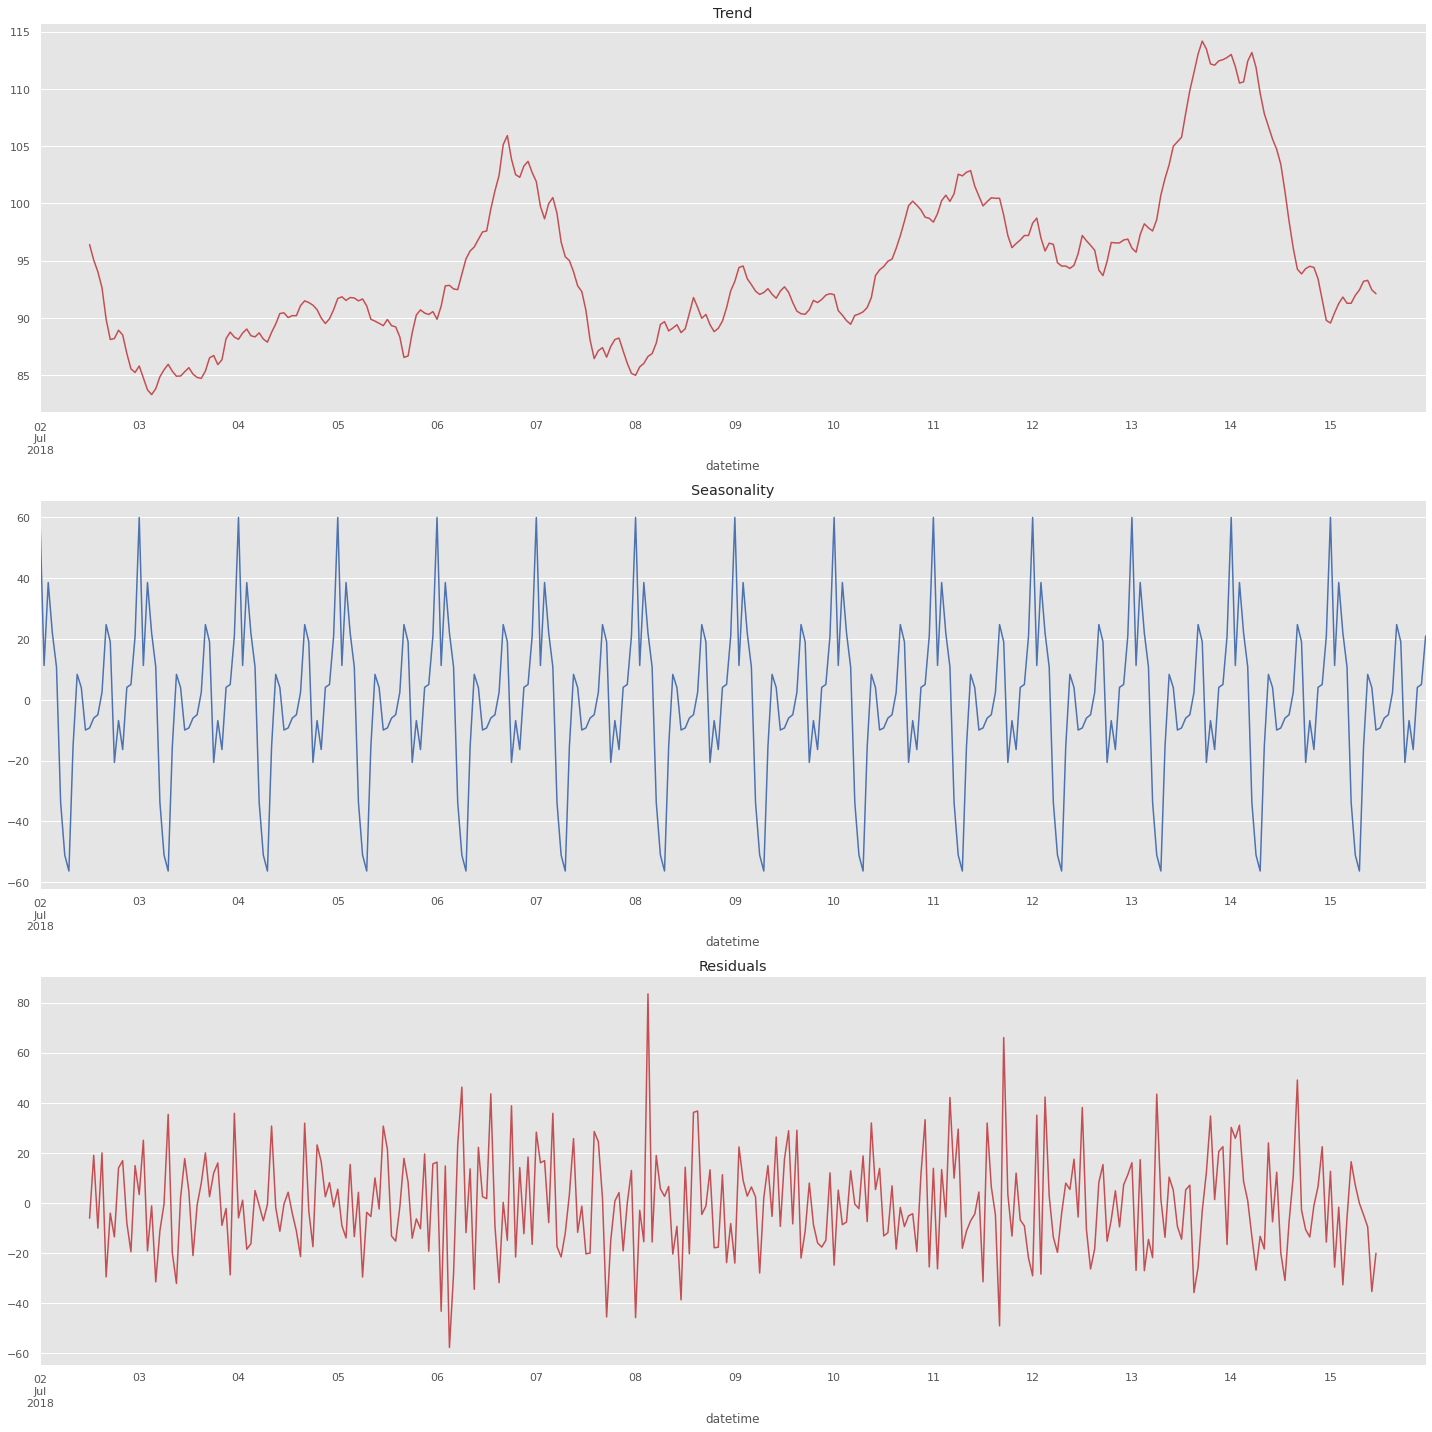

In [17]:
plt.style.use('ggplot')
decomposed = seasonal_decompose(df_2week)
plt.figure(figsize=(20, 20))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca(), color='r')
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), color='b')

plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), color='r')

plt.title('Residuals')
plt.tight_layout()

Посмотрим на данные за 3 дня

In [18]:
df_3day = df['2018-05-01':'2018-05-03']

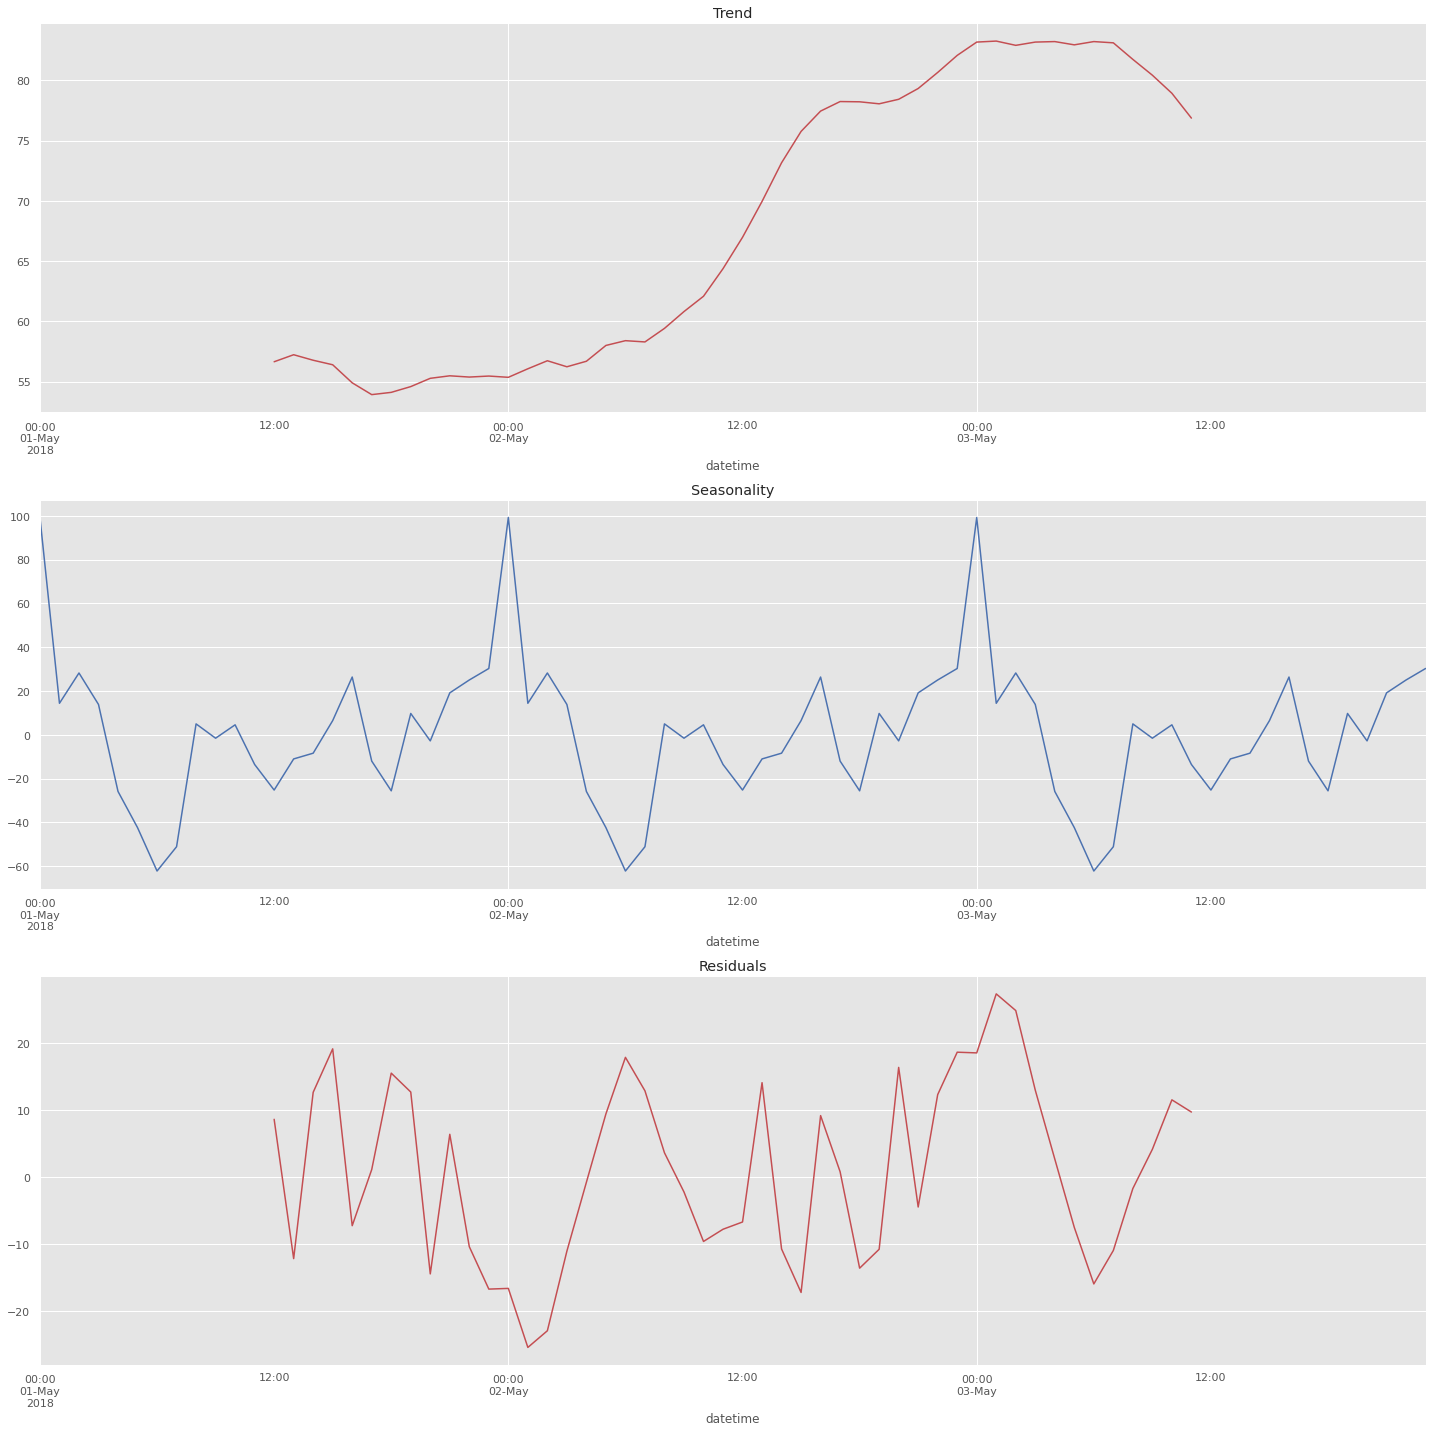

In [19]:
plt.style.use('ggplot')
decomposed = seasonal_decompose(df_3day)
plt.figure(figsize=(20, 20))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca(), color='r')
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), color='b')

plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), color='r')

plt.title('Residuals')
plt.tight_layout()

Добавим столбцы день недели и час дня. Проанализируем количество заказов в сводной таблице по среднему занчению.

In [20]:
df_copy = df.copy(deep=True)

In [21]:
df_copy['dayofweek'] = df_copy.index.dayofweek
df_copy['hour'] = df_copy.index.hour

In [22]:
df_copy.sample(15)

,num_orders,dayofweek,hour
datetime,,,
2018-06-30 17:00:00,98,5,17
2018-04-18 15:00:00,74,2,15
2018-05-09 07:00:00,16,2,7
2018-06-19 08:00:00,87,1,8
2018-08-03 19:00:00,91,4,19
2018-06-03 15:00:00,70,6,15
2018-07-05 06:00:00,11,3,6
2018-06-28 15:00:00,70,3,15
2018-06-01 12:00:00,69,4,12


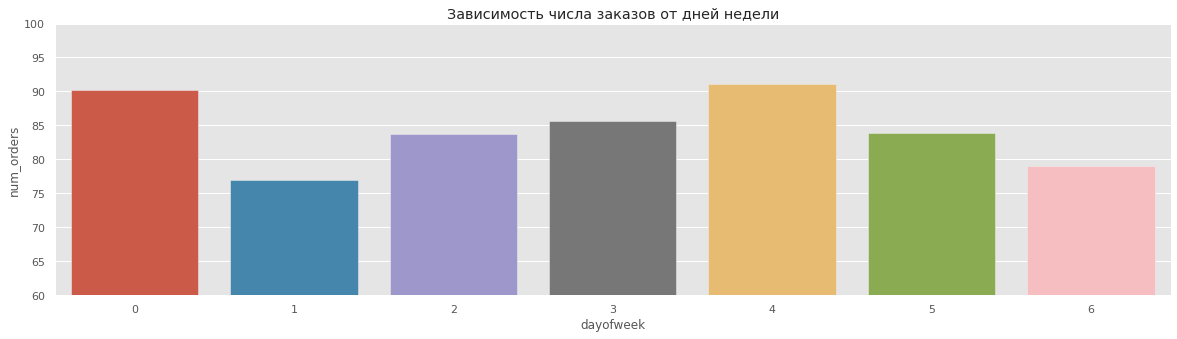

In [23]:
day_pivot = df_copy.pivot_table(index=['dayofweek'],
                              values='num_orders',
                              aggfunc='mean')
plt.figure(figsize=(20,5))
sns.barplot(x='dayofweek', y='num_orders',
            data=day_pivot.reset_index())
plt.title('Зависимость числа заказов от дней недели')
plt.ylim(60, 100)
plt.show()

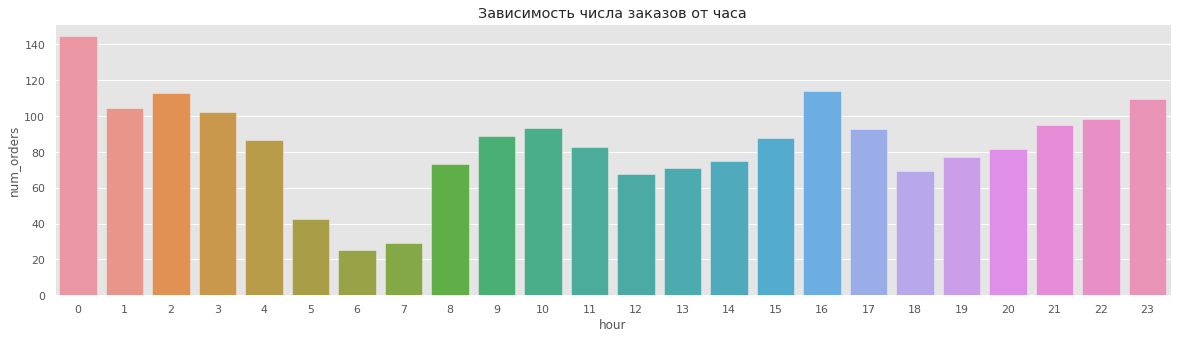

In [24]:
hour_pivot =  df_copy.pivot_table(index=['hour'],
                              values='num_orders',
                              aggfunc='mean')
plt.figure(figsize=(20,5))
sns.barplot(x='hour', y='num_orders',
            data=hour_pivot.reset_index())
plt.title('Зависимость числа заказов от часа')
plt.show()

In [25]:
df_copy.sample(15)

,num_orders,dayofweek,hour
datetime,,,
2018-05-12 19:00:00,75,5,19
2018-05-08 07:00:00,35,1,7
2018-08-21 16:00:00,128,1,16
2018-07-12 11:00:00,80,3,11
2018-04-10 16:00:00,89,1,16
2018-05-11 08:00:00,60,4,8
2018-04-26 03:00:00,114,3,3
2018-05-01 02:00:00,55,1,2
2018-04-18 14:00:00,55,2,14


<big>Вывод</big>  

Анализ заказов такси с марта по август показывает что спрос на услуги такси растет. Рост линейный.

**Тренд:**  
 

В тренде за три месяца спрос в некоторые дни ниже, в некоторые - выше. В тренде за две недели, тоже видно, что рост тренда в некоторые дни существенно выше. Возможно это связано с выходынми, праздинчными днями, может и с погодными условиями. Общий тренд нам не интересен, так как нужно предсказать спрос на такси в ближайший час.

**Сезонность:**

Хорошо заметна дневная сезонность. Наибольший спрос в 16:00 часов дня и в полночь. Наименьший спрос на такси в 6 утра.



## Обучение моделей

In [26]:
# Проверим корректность датафрейма

df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [27]:
# Подготовим функцию для создания признаков

def make_features(data, max_lag, rolling_mean_size):
    data = df.copy()
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

In [28]:
# Создадим новый датафрейм с добавленными признаками 

df_new = make_features(df, 30, 50)
df_new.head(15)

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,3,5,43.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,3,6,6.0,43.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,3,7,12.0,6.0,43.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,3,8,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 34 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   dayofweek     4416 non-null   int64  
 2   hour          4416 non-null   int64  
 3   lag_1         4415 non-null   float64
 4   lag_2         4414 non-null   float64
 5   lag_3         4413 non-null   float64
 6   lag_4         4412 non-null   float64
 7   lag_5         4411 non-null   float64
 8   lag_6         4410 non-null   float64
 9   lag_7         4409 non-null   float64
 10  lag_8         4408 non-null   float64
 11  lag_9         4407 non-null   float64
 12  lag_10        4406 non-null   float64
 13  lag_11        4405 non-null   float64
 14  lag_12        4404 non-null   float64
 15  lag_13        4403 non-null   float64
 16  lag_14        4402 non-null   float64
 17  lag_15        4401 non-null

In [30]:
df_new = df_new.dropna()

In [31]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4366 entries, 2018-03-03 02:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 34 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4366 non-null   int64  
 1   dayofweek     4366 non-null   int64  
 2   hour          4366 non-null   int64  
 3   lag_1         4366 non-null   float64
 4   lag_2         4366 non-null   float64
 5   lag_3         4366 non-null   float64
 6   lag_4         4366 non-null   float64
 7   lag_5         4366 non-null   float64
 8   lag_6         4366 non-null   float64
 9   lag_7         4366 non-null   float64
 10  lag_8         4366 non-null   float64
 11  lag_9         4366 non-null   float64
 12  lag_10        4366 non-null   float64
 13  lag_11        4366 non-null   float64
 14  lag_12        4366 non-null   float64
 15  lag_13        4366 non-null   float64
 16  lag_14        4366 non-null   float64
 17  lag_15        4366 non-null

In [32]:
# Выделяем тестовую выборку
train, test = train_test_split(df_new, test_size=0.1, shuffle=False)

In [33]:
print('Процент обучающей выборки', '{:.0%}'.format(train.shape[0]/df_new.shape[0]))

Процент обучающей выборки 90%


In [34]:
print('Процент тестовой выборки', '{:.0%}'.format(test.shape[0]/df_new.shape[0]))

Процент тестовой выборки 10%


In [35]:
train.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-03 02:00:00,25,5,2,108.0,163.0,72.0,119.0,101.0,93.0,49.0,89.0,83.0,82.0,59.0,44.0,45.0,36.0,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0,90.0,58.0,113.0,66.0,61.0,62.82
2018-03-03 03:00:00,64,5,3,25.0,108.0,163.0,72.0,119.0,101.0,93.0,49.0,89.0,83.0,82.0,59.0,44.0,45.0,36.0,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0,90.0,58.0,113.0,66.0,60.84
2018-03-03 04:00:00,44,5,4,64.0,25.0,108.0,163.0,72.0,119.0,101.0,93.0,49.0,89.0,83.0,82.0,59.0,44.0,45.0,36.0,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0,90.0,58.0,113.0,60.42
2018-03-03 05:00:00,15,5,5,44.0,64.0,25.0,108.0,163.0,72.0,119.0,101.0,93.0,49.0,89.0,83.0,82.0,59.0,44.0,45.0,36.0,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0,90.0,58.0,59.88
2018-03-03 06:00:00,9,5,6,15.0,44.0,64.0,25.0,108.0,163.0,72.0,119.0,101.0,93.0,49.0,89.0,83.0,82.0,59.0,44.0,45.0,36.0,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0,90.0,58.86


In [36]:
train.shape

(3929, 34)

In [37]:
test.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-08-13 19:00:00,91,0,19,104.0,152.0,144.0,175.0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,273.0,160.0,185.0,118.0,135.0,98.0,82.0,78.0,115.0,153.0,149.0,104.0,120.0,124.20
2018-08-13 20:00:00,82,0,20,91.0,104.0,152.0,144.0,175.0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,273.0,160.0,185.0,118.0,135.0,98.0,82.0,78.0,115.0,153.0,149.0,104.0,123.58
2018-08-13 21:00:00,160,0,21,82.0,91.0,104.0,152.0,144.0,175.0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,273.0,160.0,185.0,118.0,135.0,98.0,82.0,78.0,115.0,153.0,149.0,123.98
2018-08-13 22:00:00,104,0,22,160.0,82.0,91.0,104.0,152.0,144.0,175.0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,273.0,160.0,185.0,118.0,135.0,98.0,82.0,78.0,115.0,153.0,125.14
2018-08-13 23:00:00,134,0,23,104.0,160.0,82.0,91.0,104.0,152.0,144.0,175.0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,273.0,160.0,185.0,118.0,135.0,98.0,82.0,78.0,115.0,125.54


In [38]:
test.shape

(437, 34)

In [39]:
# Разделим предикты и целевой признак на обучающей и тестовой выборках

X_train = train.drop('num_orders', axis = 1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis = 1)
y_test = test['num_orders']

In [40]:
models_scors = pd.DataFrame(columns = ['model', 'rmse'])

### Линейная регрессия

In [41]:
# Обучим линейную регрессию

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression()

In [42]:
predicted_lr = model_lr.predict(X_test)

In [43]:
mse_lr = mean_squared_error(y_test, predicted_lr)

In [44]:
print("RMSE на тестовой выборке: {}".format(round(np.sqrt(mse_lr), 2)))

RMSE на тестовой выборке: 44.77


In [45]:
models_scors = models_scors.append({'model' : 'LinearRegression',
                     'rmse' : round(mean_squared_error(y_test, predicted_lr, squared=False),2)}, ignore_index=True)

### CatBoostRegressor

In [46]:
# Обучим CatBoostRegressor

tscv = TimeSeriesSplit(n_splits=3) 

model_CBR = CatBoostRegressor(loss_function='RMSE',
                          verbose=100,
                          thread_count=-1,
                          random_state= SEED)

grid = {'depth': [4],
        'min_data_in_leaf':[3],
        }

grid_search_result = model_CBR.grid_search(grid, cv=tscv, X=X_train, y=y_train, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 77.2745375	test: 112.4892054	best: 112.4892054 (0)	total: 50.7ms	remaining: 50.6s
100:	learn: 22.8886958	test: 40.2994009	best: 40.2994009 (100)	total: 340ms	remaining: 3.02s
200:	learn: 20.6408448	test: 35.0576677	best: 35.0576677 (200)	total: 617ms	remaining: 2.45s
300:	learn: 19.5756555	test: 33.9041249	best: 33.8869626 (299)	total: 906ms	remaining: 2.1s
400:	learn: 18.7890106	test: 33.3190744	best: 33.3190744 (400)	total: 1.17s	remaining: 1.75s
500:	learn: 18.0914124	test: 32.7180299	best: 32.7120018 (498)	total: 1.44s	remaining: 1.43s
600:	learn: 17.4569490	test: 32.3552601	best: 32.3347819 (594)	total: 1.69s	remaining: 1.12s
700:	learn: 16.8962623	test: 32.0758905	best: 32.0758905 (700)	total: 1.95s	remaining: 833ms
800:	learn: 16.3895169	test: 31.8600458	best: 31.8600458 (800)	total: 2.21s	remaining: 550ms
900:	learn: 15.8897269	test: 31.6926738	best: 31.6848032 (896)	total: 2.48s	remaining: 272ms
999:	learn: 15.4494155	test: 31.6123378	best: 31.6123378 (999)	total: 2.

In [47]:
print(f"Лучший параметр CatBoost: {grid_search_result['params']}")

Лучший параметр CatBoost: {'min_data_in_leaf': 3, 'depth': 4}


In [48]:
model_CBR = CatBoostRegressor(loss_function='RMSE',
                          verbose=100,
                          thread_count=-1,
                          random_state= SEED, depth=4, min_data_in_leaf=3)
model_CBR.fit(X_train, y_train)

Learning rate set to 0.050825
0:	learn: 37.8670835	total: 3.36ms	remaining: 3.36s
100:	learn: 23.0507150	total: 376ms	remaining: 3.34s
200:	learn: 21.2355930	total: 729ms	remaining: 2.9s
300:	learn: 19.9239982	total: 1.09s	remaining: 2.53s
400:	learn: 18.8846936	total: 1.45s	remaining: 2.17s
500:	learn: 18.0021558	total: 1.84s	remaining: 1.83s
600:	learn: 17.2426220	total: 2.2s	remaining: 1.46s
700:	learn: 16.5933360	total: 2.57s	remaining: 1.09s
800:	learn: 16.0027250	total: 2.92s	remaining: 727ms
900:	learn: 15.4143388	total: 3.29s	remaining: 361ms
999:	learn: 14.9228442	total: 3.65s	remaining: 0us


In [49]:
predicted_CBR = model_CBR.predict(X_test)
print(f'RMSE Catboost на тестовой выборке: {mean_squared_error(y_test, predicted_CBR, squared=False)}')

RMSE Catboost на тестовой выборке: 41.003420689461024


In [50]:
models_scors = models_scors.append({'model' : 'CatBoostRegressor',
                     'rmse' : mean_squared_error(y_test, predicted_CBR, squared=False)}, ignore_index=True)

### Случайны лес

In [51]:
# Обучим модель случайного леса

tscv = TimeSeriesSplit(n_splits=3) 
parametrs = {'max_depth':range(1, 5, 1), 'n_estimators': [30,100]}

In [52]:
model_rf = RandomForestRegressor(random_state=SEED)
CV_rf = GridSearchCV(model_rf, param_grid=parametrs, scoring='neg_mean_squared_error', cv=tscv, n_jobs= -1)
CV_rf.fit(X_train, y_train)
print(CV_rf.best_params_)
print(CV_rf.best_score_)
print('RMSE случайного леса:', abs(CV_rf.best_score_) ** 0.5)

{'max_depth': 4, 'n_estimators': 30}
-921.5046345389956
RMSE случайного леса: 30.356294809133008


In [53]:
model_rf = RandomForestRegressor(random_state=SEED, n_estimators=30, max_depth=4 )
model_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, n_estimators=30, random_state=12345)

In [54]:
predicted_rf = model_rf.predict(X_test)

In [55]:
mse_rf = mean_squared_error(y_test, predicted_rf)

In [56]:
print("RMSE на тестовой выборке: {}".format(round(np.sqrt(mse_rf), 2)))

RMSE на тестовой выборке: 52.79


In [57]:
models_scors = models_scors.append({'model' : 'RandomForestRegressor',
                     'rmse' : mean_squared_error(y_test, predicted_rf, squared=False)}, ignore_index=True)

In [58]:
models_scors

,model,rmse
0,LinearRegression,44.770000
1,CatBoostRegressor,41.003421
2,RandomForestRegressor,52.793572


Лучший резултат показала модель CatBoost. Построим графики фактических и предсказанных целевых показателей. Сделаем визуальный обрзор расхождений.

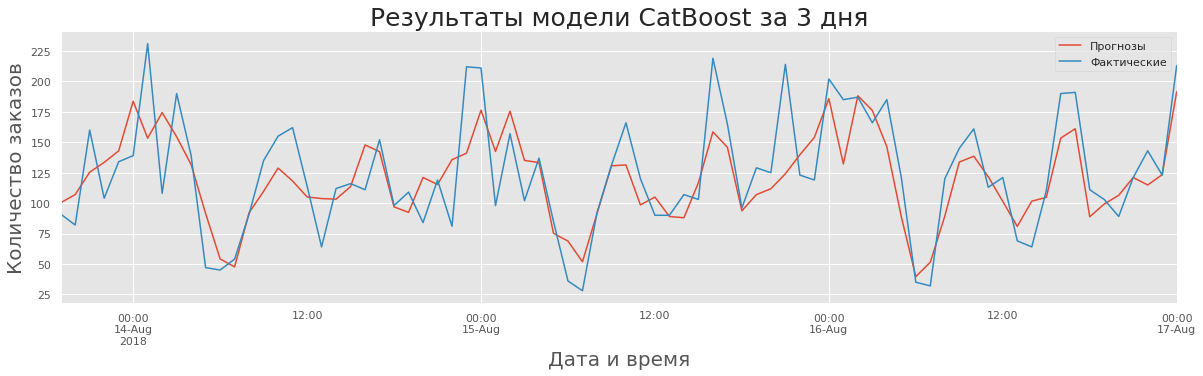

In [66]:
# Прогнозы на 3 дня для CatBoost

pd.DataFrame({'Прогнозы':predicted_CBR,
             'Фактические':y_test})[:78].plot(figsize=(20,5))
plt.title('Результаты модели CatBoost за 3 дня', fontsize=25)
plt.ylabel('Количество заказов', fontsize=20)
plt.xlabel('Дата и время', fontsize=20)
plt.show()

На графике видны расхождения в пределах полуночи, ближе к обеду, и в районе шести вечера. В пиковых часах в основном модель предсказывает необходимость меньшего количества заказов, чем на реальных данных. Простоя автопарка не будет, но и есть вероятность потери части заказов.

Вывод:

Для повышения точности моделей машинного обучения на основании исходных данных были добавлены новые features  
- День недели важен, так как в в пятницу и в понедельник заказов такси в среднем больше чем в остальные дни.
- Час временной точки, так как люди чаще заказывают такси утром и вечером.
Для предсказаний опирались также на предыдущие временные точки. 

Для предсказаний обучили 3 модели регрессии.
- линейная регрессия
- случайный лес
- CatBoostRegressor

Наилучший показатель RMSE = 41, у модели CatBoostRegressor. Показатель удовлетворяет ограничениям указанным в постановке задачи RMSE не более 48.  

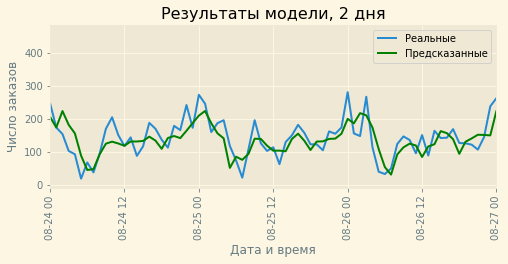